In [1]:
import os, sys, pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import manifold_dynamics.utils_txt as tut

In [38]:
DATA_DIR = '../../datasets/NNN/'
# IMG_DIR = '../../datasets/NNN/NSD1000_LOC'

CAT = 'face'
dat = pd.read_pickle(os.path.join(DATA_DIR, (f'{CAT}_roi_data.pkl')))
ROI_LIST = list(dat['roi'].unique())
print(f'Unique {CAT} ROIs: {ROI_LIST}')

# optimal k: the optimal manifold scale at which we should conduct analyses
# see ./pause.ipynb
with open(f'../../datasets/NNN/{CAT}_mins.pkl', 'rb') as f:
    mins = pickle.load(f)
SCALES = {k: v[0] for k,v in mins.items()}

SAVE_DIR = '../../../buckets/manifold-dynamics/time-time/'
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
if not os.path.exists(os.path.join(SAVE_DIR, 'ed-range')):
    os.makedirs(os.path.join(SAVE_DIR, 'ed-range'))

Unique face ROIs: ['Unknown_19_F', 'MF1_9_F', 'MF1_8_F', 'AF3_18_F', 'MF1_7_F', 'Unknown_5_F', 'AMC3_28_F']


In [53]:
ROI = 'MF1_7_F'  # Unknown_19_F, MF1_7_F, MF1_8_F, MF1_9_F, AF3_18_F, MB1_3_B
MODE = 'top'
scale = SCALES[ROI]

T, win = 350, 20
# start of time window
t0_vals = np.arange(0, T, 10)
# length of time window
win_vals = np.arange(100, 300, win) 

ED = np.full((len(t0_vals), len(win_vals)), np.nan, dtype=float)
for i, t0 in enumerate(tqdm(t0_vals, desc='t0')):
    for j, win in enumerate(win_vals):
        t1 = t0 + win
        if t1 > T:
            continue
        try:
            Rt, _ = tut.static_rdm(dat, ROI, mode=MODE, scale=scale, tstart=int(t0), tend=int(t1))
            ED[i, j] = tut.ED2(Rt)
        except Exception:
            # if a window fails (e.g., too few units/images), leave nan
            continue
ED = ED.T

t0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


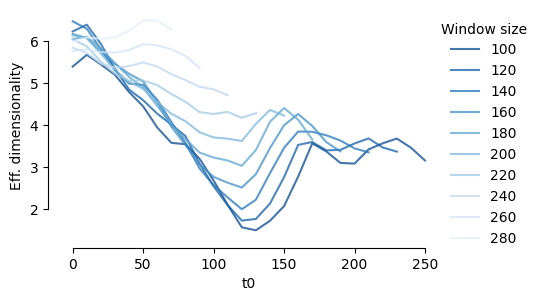

In [54]:
fig,ax = plt.subplots(1,1, figsize=(5,3))
customp = sns.color_palette('Blues_r', len(ED))

for i, t0 in enumerate(ED):
    sns.lineplot(t0, alpha=0.75, color=customp[i], label=f'{100+20*i}', ax=ax)

ax.set_xticks(np.arange(0, 30, 5))
ax.set_xticklabels(np.arange(0, 300, 50))

ax.legend(title='Window size', loc='upper right', bbox_to_anchor=(1.25, 1), frameon=False)

ax.set_ylabel('Eff. dimensionality')
ax.set_xlabel('t0')

# plot the selected combo used for analysis
i_sel = 4          # which t0 / curve
x_sel = 10         # x index
y_sel = ED[i_sel][x_sel]
# ax.scatter(x_sel, y_sel, color='red', marker='.', zorder=10)


sns.despine(fig=fig, trim=True, offset=5)
out_path = os.path.join(SAVE_DIR, 'ed-range', f'{ROI}.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight', transparent=True)
plt.show()